<a href="https://colab.research.google.com/github/rohitgkr/MachineLearning/blob/main/Insurance_Business_Prediction_RandomForest_MPL_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this experiment is to analyze historical insurance quote requests and predict the probability of business conversion based on multidimensional parameters (ex. brokerage, region, class, EPI gross, limit etc. to name a just few). This could help increase business efficiency by prioritising quote requests that have higher likelihood of business conversion.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
import matplotlib.pyplot as plt

# Change the file path to the new dataset
file_path = "/content/drive/MyDrive/data/prepared_data_2024-business.csv"
df = pd.read_csv(file_path)

# Define the new target variable ('Line Status') and features (all others)
target_col = 'Line Status' # Change target column name
y = df[target_col]
X = df.drop(columns=[target_col])

# Collapse the target variable into 4 classes
def collapse_line_status(status):
    if status in ['Signed', 'Written']:
        return 'conversion'
    elif status == 'Decline':
        return 'reject'
    elif status == 'NTU':
        return 'NTU'
    else:
        return 'unknown'

y = y.apply(collapse_line_status)

# Clean 'Limit' and 'Exposure USD' columns
for col in ['Limit', 'Exposure USD']:
    if col in X.columns:
        # Remove commas and convert to numeric, coercing errors to NaN
        X[col] = pd.to_numeric(X[col].astype(str).str.replace(',', ''), errors='coerce')
        # Fill NaN values with 0
        X[col] = X[col].fillna(0)


#  categorical columns to One-Hot Encode
categorical_cols = [
    'Minor Class',      # Column A
    'Class',            # Column B
    'Entity',           # Column C - Added Entity to categorical columns
    'Placing Type',     # Column D
    'Renewal Ind',      # Column E
    ]

# verify  columns exist
missing = set(categorical_cols) - set(X.columns)
if missing:
    raise KeyError(f"Missing expected categorical columns: {missing}")

In [ ]:
display(y)

,Line Status
0,unknown
1,unknown
2,NTU
3,unknown
4,unknown
...,...
4517,unknown
4518,unknown
4519,unknown
4520,unknown


In [ ]:
display(X)

,Minor Class,Class,Entity,Placing Type,Renewal Ind,Broker Index,Limit,Exposure USD
0,PV excluding War & Civil War,PD & BI,3000,Open Market,New,67,0,0.0
1,SRCCMD,PD & BI,3000,Open Market,New,72,0,0.0
2,Sabotage and Terrorism,PD,3000,Open Market,New,67,0,0.0
3,Sabotage and Terrorism,PD & BI,3000,Open Market,New,67,0,0.0
4,Sabotage and Terrorism,PD & BI,3000,Open Market,New,67,0,0.0
...,...,...,...,...,...,...,...,...
4517,Sabotage and Terrorism,PD & BI,MISE,Open Market,New,72,0,0.0
4518,Full PV,PD & BI,MISE,Open Market,New,72,0,0.0
4519,SRCCMD,PD & BI,MISE,Fac RI,New,9,0,0.0
4520,Sabotage and Terrorism,PD & BI,MISE,Open Market,New,9,0,0.0


In [ ]:

# One-Hot Encoding (drop='first' to avoid collinearity)
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_arr = encoder.fit_transform(X[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Rebuild X with encoded features + remaining numeric columns
X_enc = pd.concat([
    X.drop(columns=categorical_cols).reset_index(drop=True),
    pd.DataFrame(encoded_arr, columns=encoded_cols)
], axis=1)


In [ ]:
# train & test sets (stratify by target)
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
# train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100, # Number of trees in the forest
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

In [ ]:
# performance
train_acc = rf_clf.score(X_train, y_train)
test_acc  = rf_clf.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test  accuracy: {test_acc:.2f}\n")

Train accuracy: 0.88
Test  accuracy: 0.88



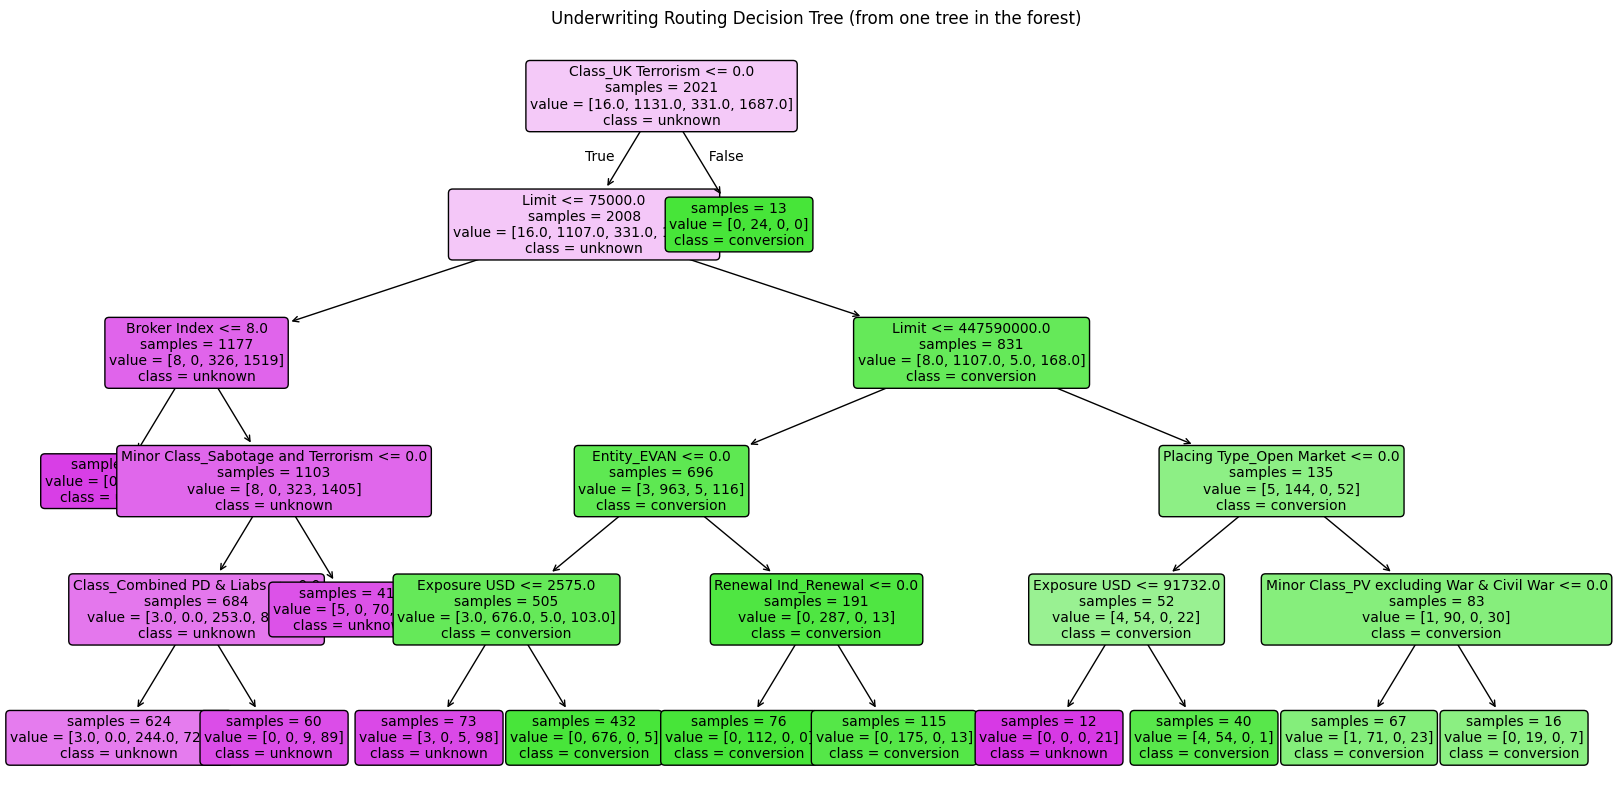

In [ ]:
# print decision rules (Note: Decision rules are not typically extracted and printed for a Random Forest in the same way as a single Decision Tree. We'll remove this part.)
feature_names = X_enc.columns.tolist()
rules = export_text(rf_clf.estimators_[0], feature_names=feature_names) # Example for one tree
#print("Decision Tree Rules (from one tree in the forest):\n")
#print(rules)

# Visualize the tree (Note: Visualizing all trees in a Random Forest is not practical. We'll remove this part.)
plt.figure(figsize=(20, 10))
plot_tree(
    rf_clf.estimators_[0], # Example for one tree
    feature_names=feature_names,
    class_names=rf_clf.classes_,
    filled=True,
    rounded=True,
    fontsize=10,
    proportion=False,
    node_ids=False,
    impurity=False,
    precision=0
)
plt.title("Underwriting Routing Decision Tree (from one tree in the forest)")
plt.show()

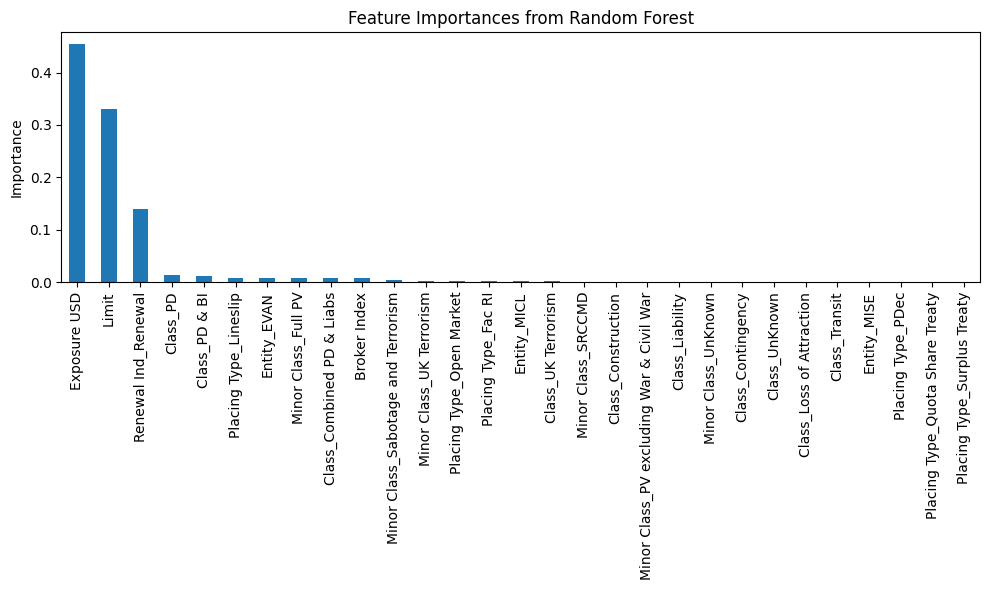


Feature Importances:
Exposure USD                                0.454231
Limit                                       0.329679
Renewal Ind_Renewal                         0.139024
Class_PD                                    0.014122
Class_PD & BI                               0.010846
Placing Type_Lineslip                       0.008175
Entity_EVAN                                 0.007665
Minor Class_Full PV                         0.007620
Class_Combined PD & Liabs                   0.007384
Broker Index                                0.006778
Minor Class_Sabotage and Terrorism          0.003435
Minor Class_UK Terrorism                    0.002214
Placing Type_Open Market                    0.002062
Placing Type_Fac RI                         0.002022
Entity_MICL                                 0.001348
Class_UK Terrorism                          0.001103
Minor Class_SRCCMD                          0.000897
Class_Construction                          0.000768
Minor Class_PV excluding

In [ ]:


# Instead of visualizing a single tree, you can look at feature importances
importances = pd.Series(rf_clf.feature_importances_, index=X_enc.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title("Feature Importances from Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

print("\nFeature Importances:")
print(importances)

# Prediction...
Define a function to predict the underwriter based on the extracted rules.



In [ ]:
# predicted_underwriters = X_test.apply(lambda row: predict_underwriter(row, underwriter_rules), axis=1).tolist()
predicted_underwriters = rf_clf.predict(X_test).tolist() # Use the Random Forest model's predict method
print(predicted_underwriters[:10])

['conversion', 'unknown', 'conversion', 'unknown', 'conversion', 'conversion', 'conversion', 'unknown', 'unknown', 'unknown']


## Evaluation


In [ ]:
# Display collapsed class histogram
print("Counts per collapsed 'Line Status' class:")
display(y.value_counts())

Counts per collapsed 'Line Status' class:


,count
Line Status,
unknown,2319
conversion,1687
reject,489
NTU,27


Now that we have trained the Random Forest model, let's evaluate its performance and visualize the results.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_underwriters)
print(f"Accuracy of implemented rules: {accuracy:.2f}\n")

# Get all unique classes from the original target variable
all_classes = sorted(y.unique())

# Generate and print classification report, specifying all possible labels
report = classification_report(y_test, predicted_underwriters, labels=all_classes, zero_division=0)
print("Classification Report:\n")
print(report)

Accuracy of implemented rules: 0.88

Classification Report:

              precision    recall  f1-score   support

         NTU       0.00      0.00      0.00         8
  conversion       0.99      1.00      0.99       506
      reject       0.00      0.00      0.00       147
     unknown       0.82      0.99      0.89       696

    accuracy                           0.88      1357
   macro avg       0.45      0.50      0.47      1357
weighted avg       0.79      0.88      0.83      1357



In [ ]:
# Create a DataFrame for side-by-side comparison
comparison_df = pd.DataFrame({
    'Original State': y_test,
    'Predicted State': predicted_underwriters
})

# Display the comparison DataFrame
print("Side-by-Side Comparison of Original and Predicted Underwriters (Test Data):")
display(comparison_df.head(10))

Side-by-Side Comparison of Original and Predicted Underwriters (Test Data):


,Original State,Predicted State
2580,conversion,conversion
61,unknown,unknown
2141,conversion,conversion
937,unknown,unknown
3216,conversion,conversion
2865,conversion,conversion
832,conversion,conversion
557,reject,unknown
1411,reject,unknown
1225,reject,unknown


## Result




In [ ]:
print("Model Performance Summary:")
print(f"Overall Accuracy: {accuracy:.2f}\n")
print("Classification Report:")
print(report)

print("\nKey Findings from Feature Importances:")
print("The following features were most influential in the model's predictions:")
print(importances.head())

Model Performance Summary:
Overall Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

         NTU       0.00      0.00      0.00         8
  conversion       0.99      1.00      0.99       506
      reject       0.00      0.00      0.00       147
     unknown       0.82      0.99      0.89       696

    accuracy                           0.88      1357
   macro avg       0.45      0.50      0.47      1357
weighted avg       0.79      0.88      0.83      1357


Key Findings from Feature Importances:
The following features were most influential in the model's predictions:
Exposure USD           0.454231
Limit                  0.329679
Renewal Ind_Renewal    0.139024
Class_PD               0.014122
Class_PD & BI          0.010846
dtype: float64


* RandomForest model accuracy = 0.88.
* Performance is good for predicting 'conversion' and 'unknown' classes
* Prediction is ZERO for 'NTU' & 'reject' classes
* Most influential features => 'Exposure USD' (0.49), 'Limit' (0.30), and 'Renewal Ind_Renewal' (0.13).
